# Análisis e interpretación de Datos

###Actividad Grupal: Definición de modelos estadísticos.

##Objetivo

Analizar la información referente al desarrollo de la pandemia en México y Perú, para determinar si los procesos de vacunación tienen o no un efecto positivo en la disminución de defunciones. Así como analizar si las reestricciones impuestas por los gobiernos de cada país tuvieron un impacto en la reducción de contagios o muertes.

La información utilizada para este análisis, se encuentra en el repositorio público "COVID-19 Dataset by Our World in Data",el cual mantiene información actualizada de diferentes países.

In [1]:
#@title Importar bibliotecas y lectura de fuente de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
globalcovid = pd.read_csv(url, index_col=0)

Dado que este análisis es solo para comparar el comportamiento entre México y Perú, únicamente se filtra la información para estos paises, se crean datos como el "Año", "Mes" y "Semana" para poder agrupar por estos campos y se obtienen solo los campos a analizar. 

En este caso se agrupa la información por país, año y semana para segmentar la información.

In [2]:
#@title Limpieza y transformación
#Filtrar por paises
searchcountries = ['Peru', 'Mexico']

mexpercovid = globalcovid[['location', 'date', 'population', 'total_cases',
                           'new_cases', 'total_deaths', 'new_deaths', 
                           'total_vaccinations', 'people_vaccinated', 
                           'people_fully_vaccinated', 'new_vaccinations', 
                           'stringency_index', 'human_development_index']
             ].loc[globalcovid['location'].isin(searchcountries)]

#Convertir a fecha y contruir campos para agrupaciones
mexpercovid['date'] = pd.to_datetime(mexpercovid['date'])
mexpercovid[['population', 'total_cases', 'new_cases', 'total_deaths', 
             'new_deaths', 'total_vaccinations', 'people_vaccinated', 
             'people_fully_vaccinated', 'new_vaccinations']] = mexpercovid[['population', 
             'total_cases', 'new_cases', 'total_deaths', 
             'new_deaths', 'total_vaccinations', 'people_vaccinated', 
             'people_fully_vaccinated', 'new_vaccinations']].fillna(0).astype(int)
mexpercovid['year'], mexpercovid['month'], mexpercovid['week'], mexpercovid['yearweek'] = mexpercovid['date'].dt.year, mexpercovid['date'].dt.month, mexpercovid['date'].dt.isocalendar().week, mexpercovid['date'].dt.to_period('W')
 

#Obtener únicamente los campos utilizados en este análisis, agrupados por país, año
covidrestmex = mexpercovid.groupby(['location', 'yearweek']).agg({'stringency_index': 'max', 'new_cases':'sum','new_deaths':'sum', 'new_vaccinations': 'sum'}).reset_index()

covidrestmex = covidrestmex.replace(0, np.NaN)

#Normalización de valores
x = covidrestmex[['new_cases', 'new_deaths', 'new_vaccinations']].values #returns a numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.rename(columns = {0: 'Activos', 1: 'Defunciones', 2: 'Vacunados'}, inplace=True)
df

covidrestmex = pd.concat([covidrestmex, df], axis=1)

In [3]:
#@title Dataframe Resultado:
covidrestmex

,location,yearweek,stringency_index,new_cases,new_deaths,new_vaccinations,Activos,Defunciones,Vacunados
0,Mexico,2019-12-30/2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mexico,2020-01-06/2020-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mexico,2020-01-13/2020-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mexico,2020-01-20/2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mexico,2020-01-27/2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
213,Peru,2021-12-27/2022-01-02,71.30,23379.0,258.0,1318447.0,0.068751,0.028700,0.137708
214,Peru,2022-01-03/2022-01-09,68.52,73135.0,285.0,1978382.0,0.215083,0.031726,0.206886
215,Peru,2022-01-10/2022-01-16,68.52,230313.0,397.0,1556092.0,0.677339,0.044283,0.162620
216,Peru,2022-01-17/2022-01-23,68.52,340025.0,859.0,952317.0,1.000000,0.096076,0.099329


In [15]:
#@title Crear un dataframe por cada país
#Filtrar datasets por país y año
covidrestmex1 = covidrestmex.loc[(covidrestmex['location'] == 'Mexico') & (covidrestmex['yearweek'].astype(str).str[0:4].astype(int) >= 2021)]
covidrestper = covidrestmex.loc[(covidrestmex['location'] == 'Peru') & (covidrestmex['yearweek'].astype(str).str[0:4].astype(int) >= 2021)]
covid2021 = covidrestmex.loc[(covidrestmex['yearweek'].astype(str).str[0:4].astype(int) >= 2021)]

In [19]:
covidrestper

,location,yearweek,stringency_index,new_cases,new_deaths,new_vaccinations,Activos,Defunciones,Vacunados
162,Peru,2021-01-04/2021-01-10,61.11,8081.0,1401.0,NaN,0.023760,0.156839,NaN
163,Peru,2021-01-11/2021-01-17,61.11,34387.0,2027.0,NaN,0.101126,0.227018,NaN
164,Peru,2021-01-18/2021-01-24,61.11,33371.0,2907.0,NaN,0.098137,0.325673,NaN
165,Peru,2021-01-25/2021-01-31,77.78,44301.0,3900.0,NaN,0.130282,0.436996,NaN
166,Peru,2021-02-01/2021-02-07,86.11,48459.0,4052.0,NaN,0.142511,0.454036,NaN
167,Peru,2021-02-08/2021-02-14,86.11,48600.0,4761.0,111002.0,0.142926,0.533520,0.011138
168,Peru,2021-02-15/2021-02-21,86.11,48011.0,5122.0,91514.0,0.141193,0.573991,0.009095
169,Peru,2021-02-22/2021-02-28,86.11,40554.0,4757.0,119813.0,0.119263,0.533072,0.012061
170,Peru,2021-03-01/2021-03-07,86.11,41101.0,4737.0,129556.0,0.120871,0.530830,0.013083
171,Peru,2021-03-08/2021-03-14,86.11,42999.0,4296.0,155763.0,0.126453,0.481390,0.015830


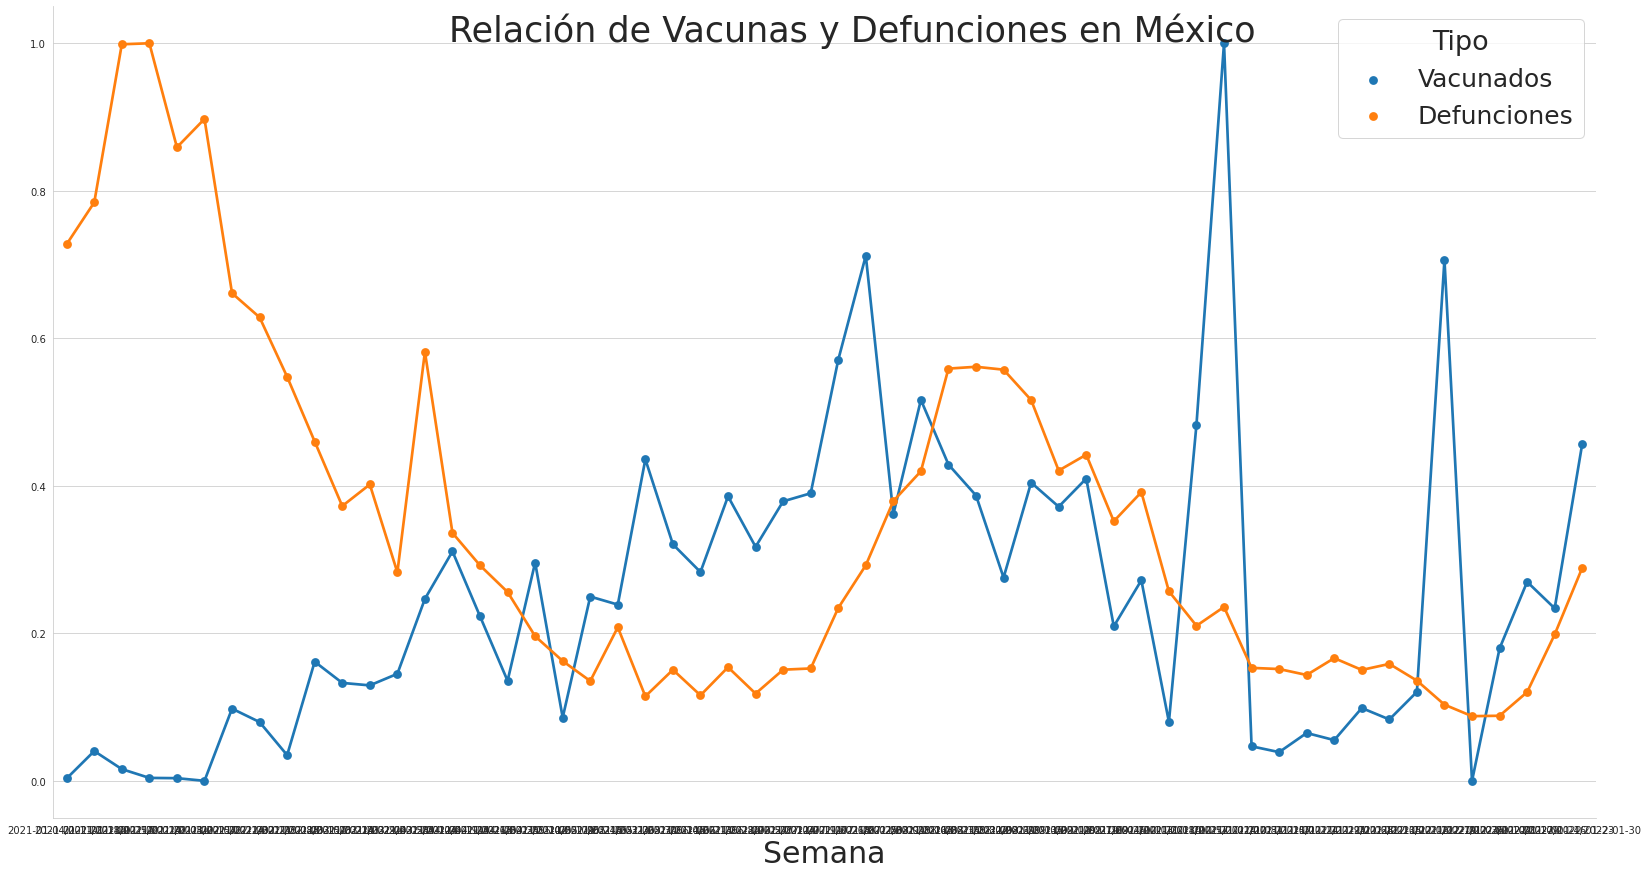

In [16]:
#@title Relación de vacunas y defunciones en México
dfm = covidrestmex1[['yearweek', 'Vacunados', 'Defunciones']].melt('yearweek', var_name='cols', value_name='vals')

dfm.rename(columns = {'yearweek': 'Semana', 'cols': 'Tipo'}, inplace=True)
sns.set_style("whitegrid")
g = sns.catplot(x="Semana", 
                y="vals", 
                hue='Tipo', 
                data=dfm, 
                kind='point',
                height=12, aspect=15/8)
g.set_axis_labels("Semana", "", fontsize=30)
g.fig.suptitle('Relación de Vacunas y Defunciones en México', fontsize=35)
g._legend.remove()

plt.legend(title='Tipo', fontsize='25', title_fontsize='27')

In [ ]:
#@title Relación de vacunas y defunciones en Perú
dfm = covidrestper[['week', 'Vacunados', 'Defunciones']].melt('week', var_name='cols', value_name='vals')

dfm.rename(columns = {'week': 'Semana', 'cols': 'Tipo'}, inplace=True)
sns.set_style("whitegrid")
g = sns.catplot(x="Semana", 
                y="vals", 
                hue='Tipo', 
                data=dfm, 
                kind='point',
                height=12, aspect=15/8)
g.set_axis_labels("Semana", "", fontsize=30)
g.fig.suptitle('Relación de Vacunas y Defunciones en Perú', fontsize=35)
g._legend.remove()

plt.legend(title='Tipo', fontsize='25', title_fontsize='27')

In [ ]:
#@title Relación de vacunas y defunciones en Perú
#dfm.rename(columns = {'week': 'Semana', 'cols': 'Tipo'}, inplace=True)
sns.set_style("whitegrid")
g = sns.lmplot(x="Vacunados", 
               y="Defunciones", 
               data=covid2021, 
               #x_estimator=np.mean, 
               hue='location',
               height=12, aspect=15/8)
g.set_axis_labels("Vacunados", "Defunciones", fontsize=30)
g.fig.suptitle('Regresión sobre Vacunas y Defunciones', fontsize=35)
g._legend.remove()

plt.legend(title='', fontsize='25', title_fontsize='27')



In [ ]:
sns.regplot(x="Vacunados", y="Defunciones", data=covidrestmex1, x_estimator=np.mean);

In [ ]:
sns.regplot(x="Vacunados", y="Defunciones", data=covidrestper);

In [ ]:
sns.regplot(x="stringency_index", y="Activos", data=covidrestmex1);

In [ ]:
sns.regplot(x="stringency_index", y="new_cases_norm", data=covidrestper);

In [ ]:
mexpercovid.groupby(['location', 'year', 'month']).agg({'new_cases':'sum','new_deaths':'sum', 'new_vaccinations': 'sum'}).to_csv('mexpercovid.csv')